<a href="https://colab.research.google.com/github/diofares/LLM-Estatistica-Atividade4/blob/main/LLM_Estatistica_Atividade4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#B:
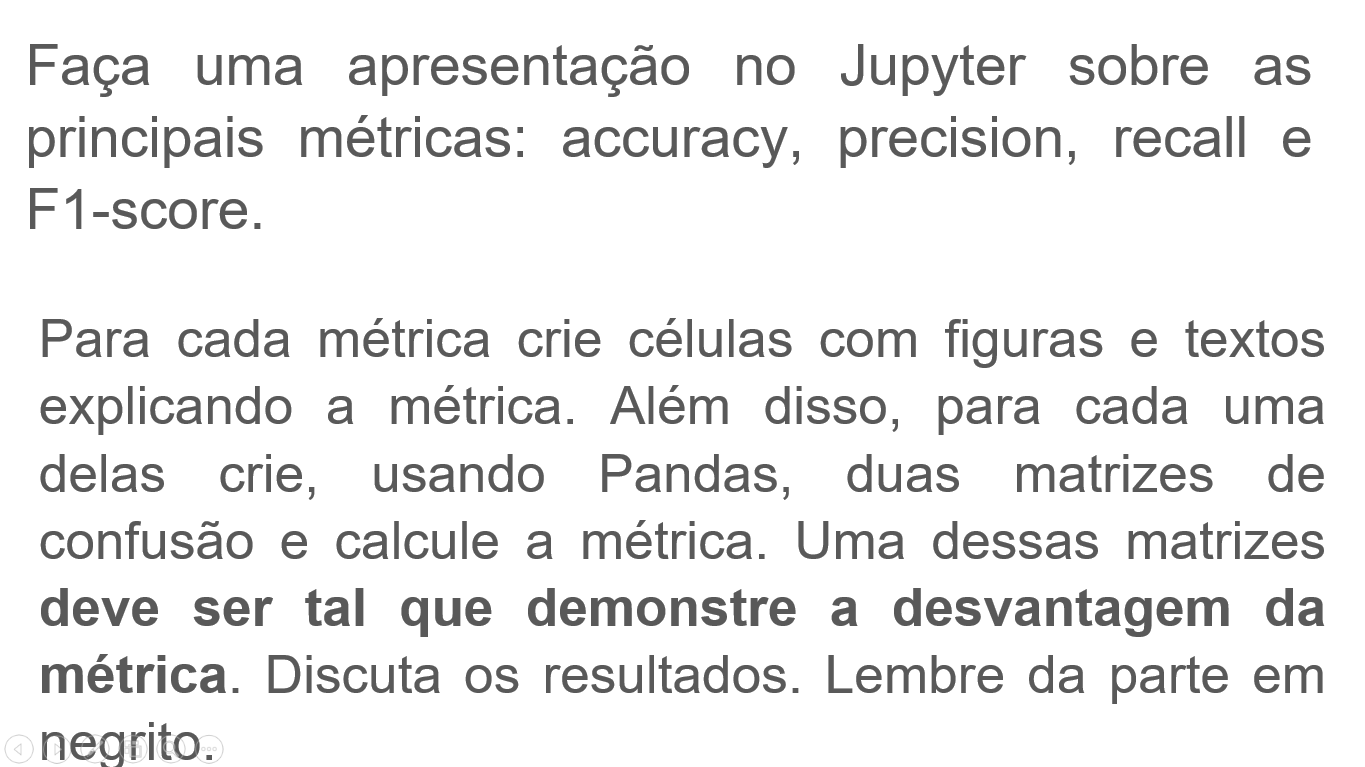

#C:
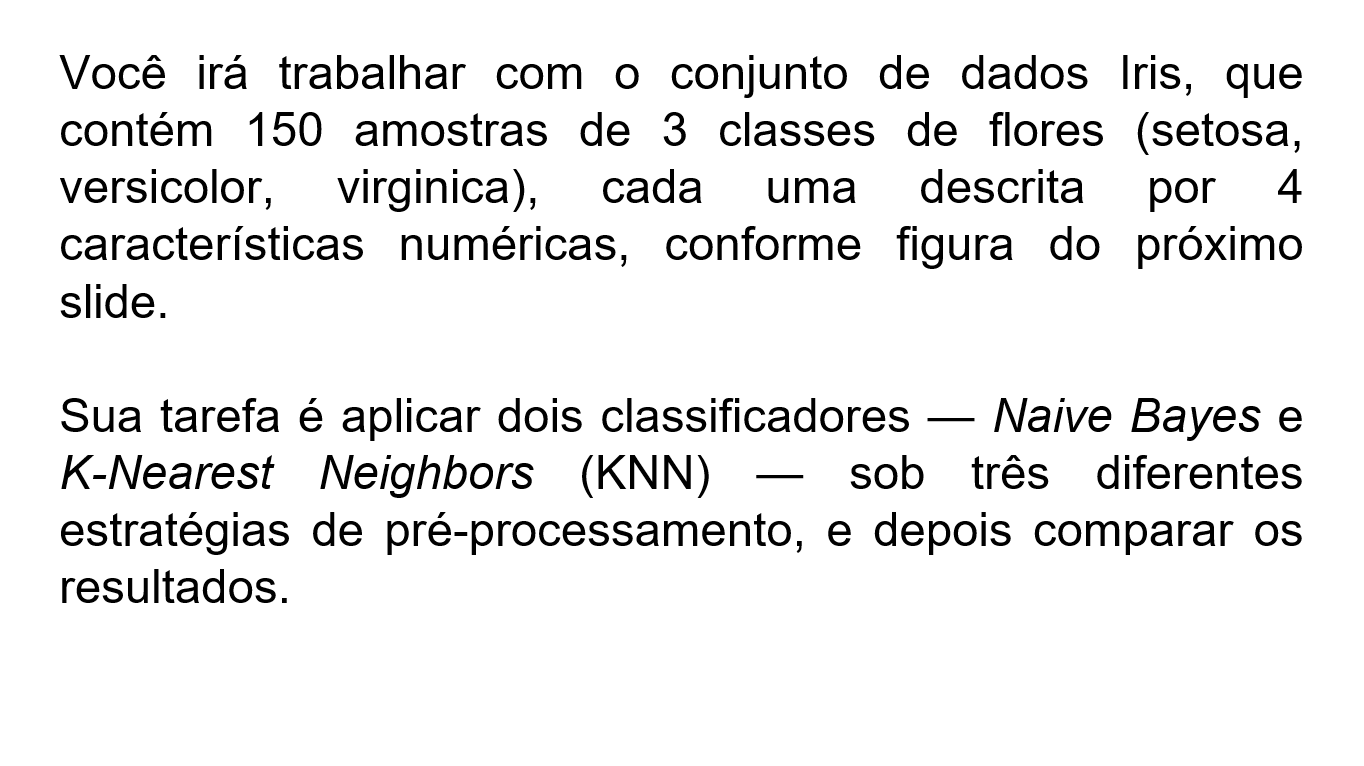
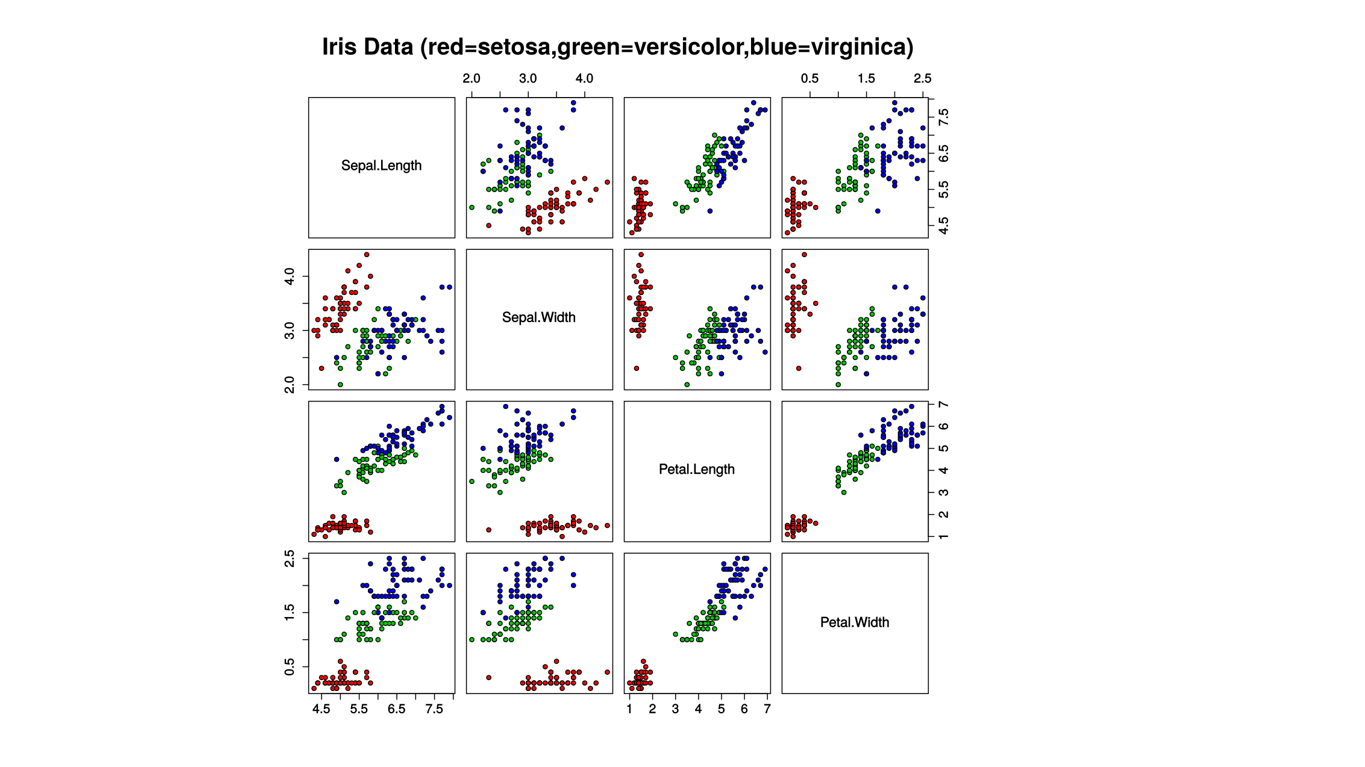
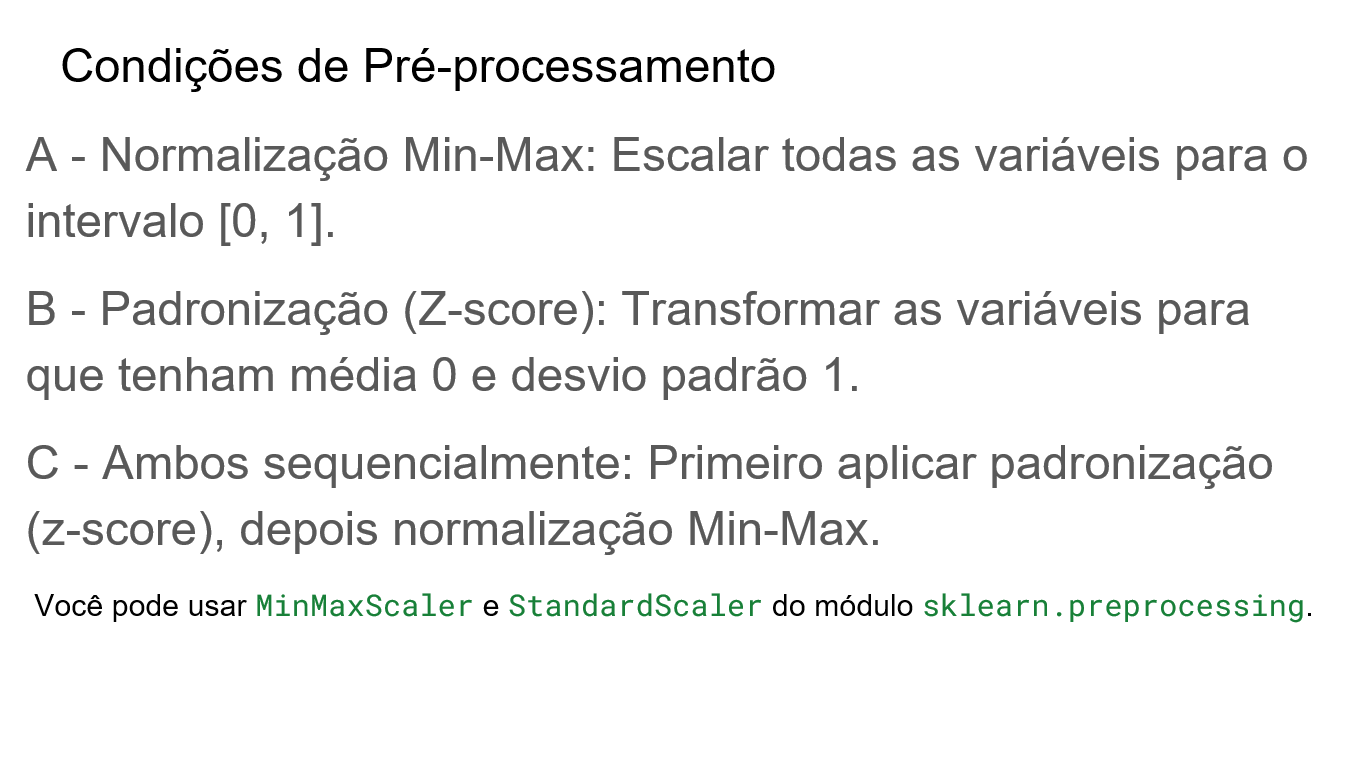
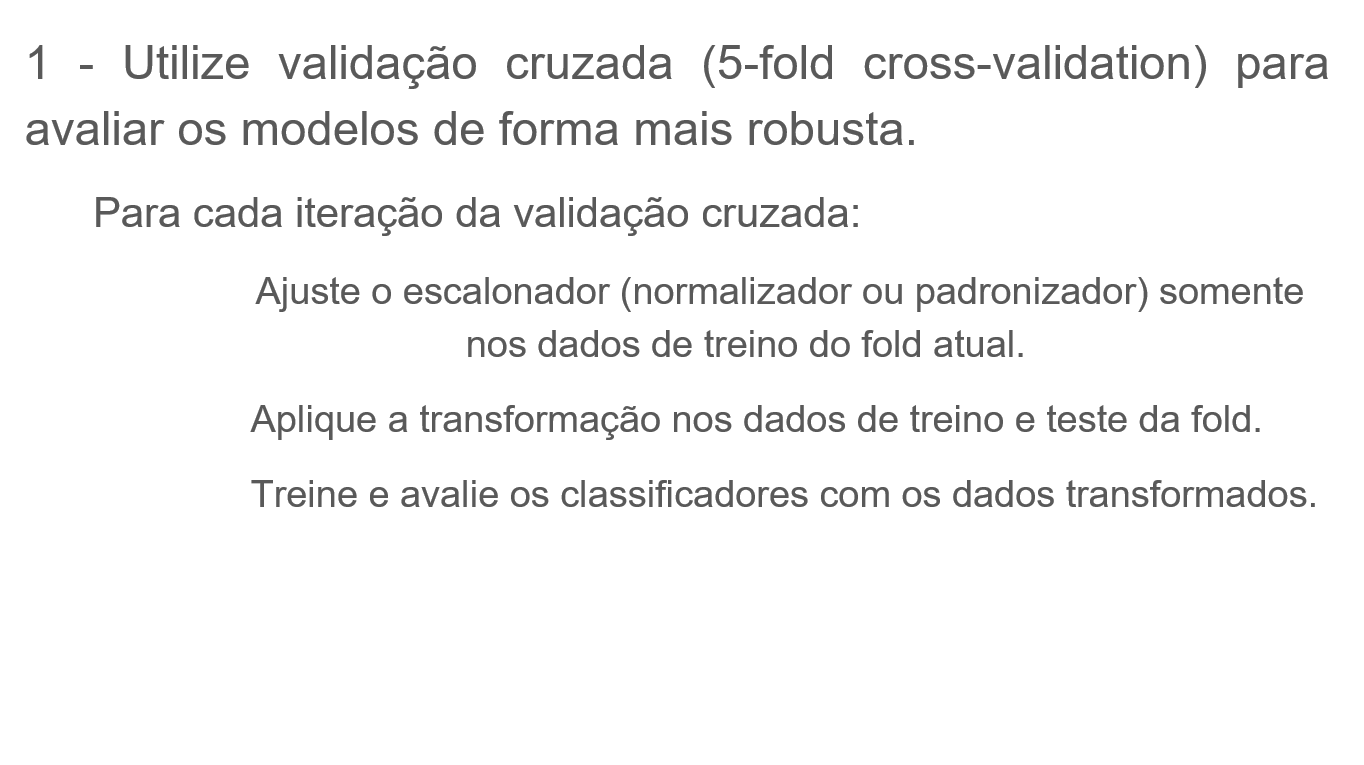
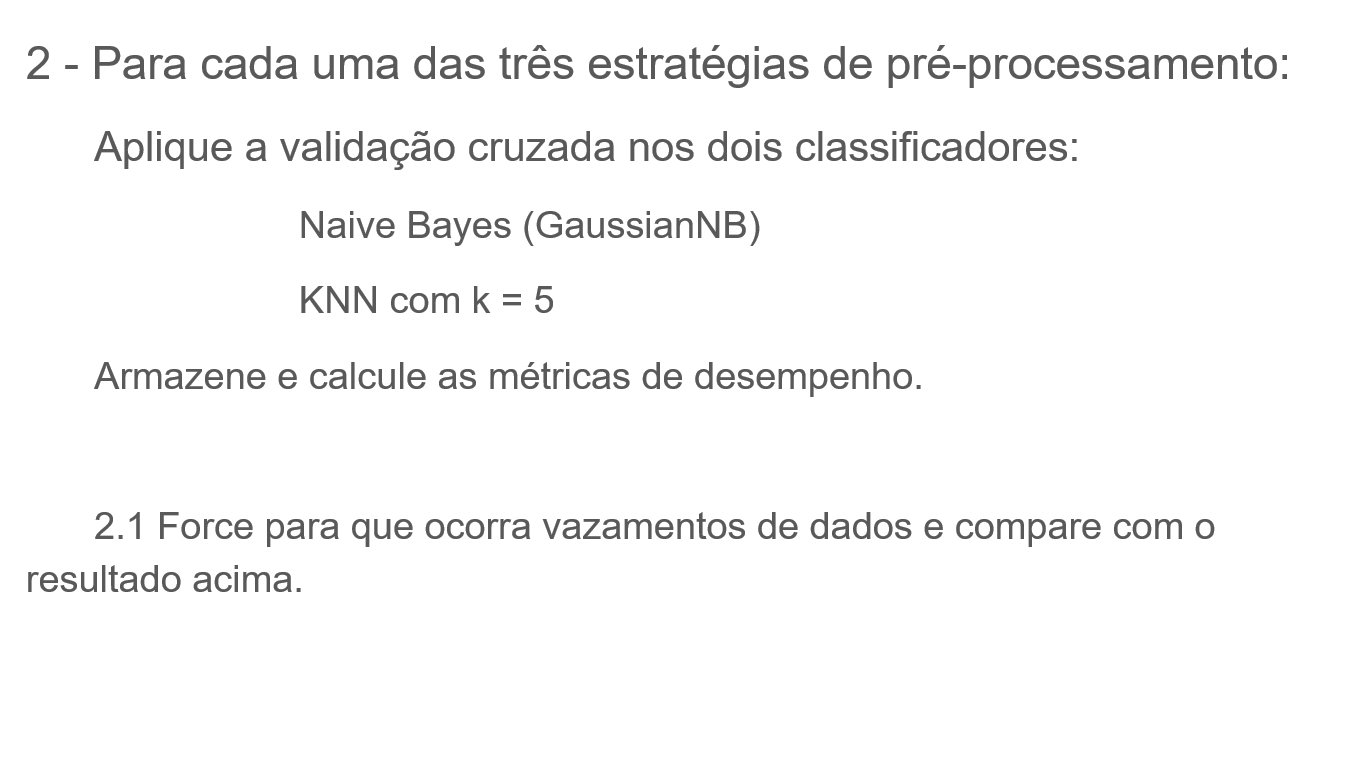
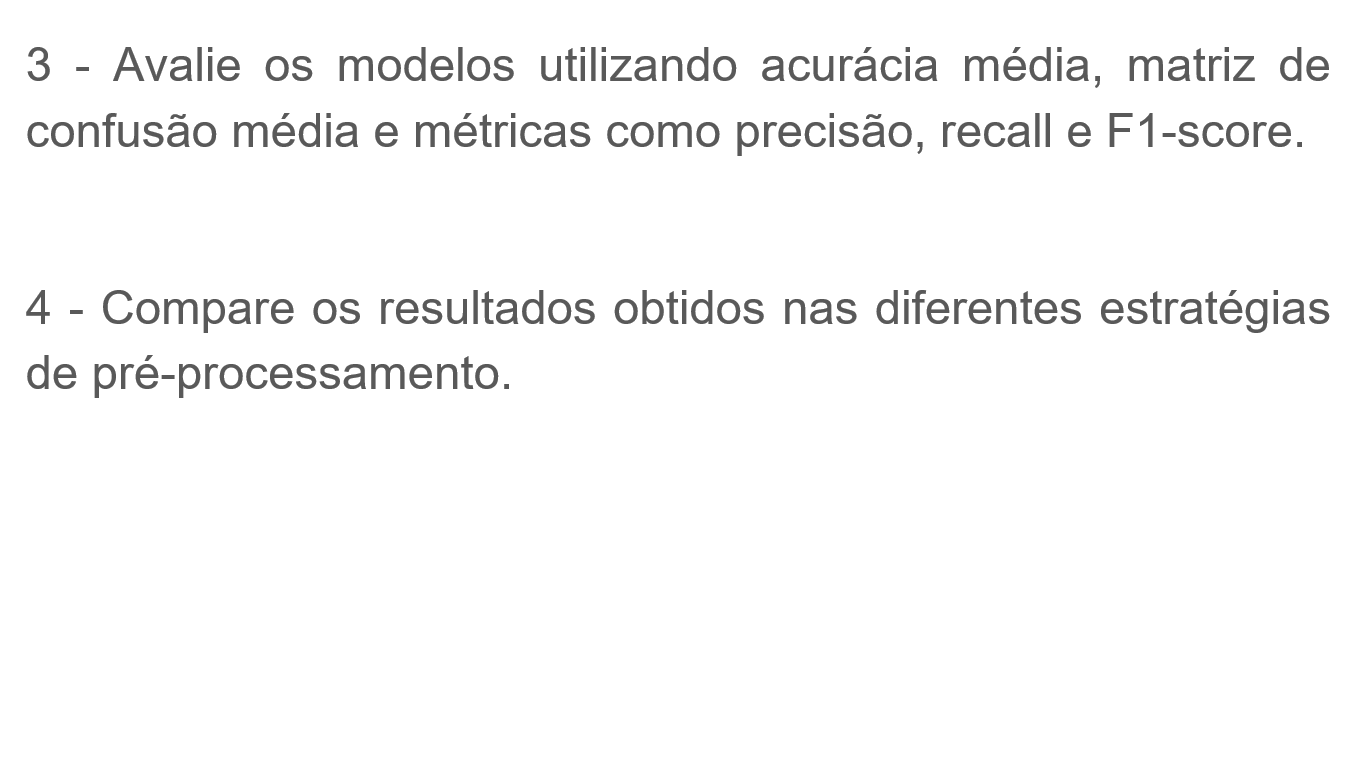
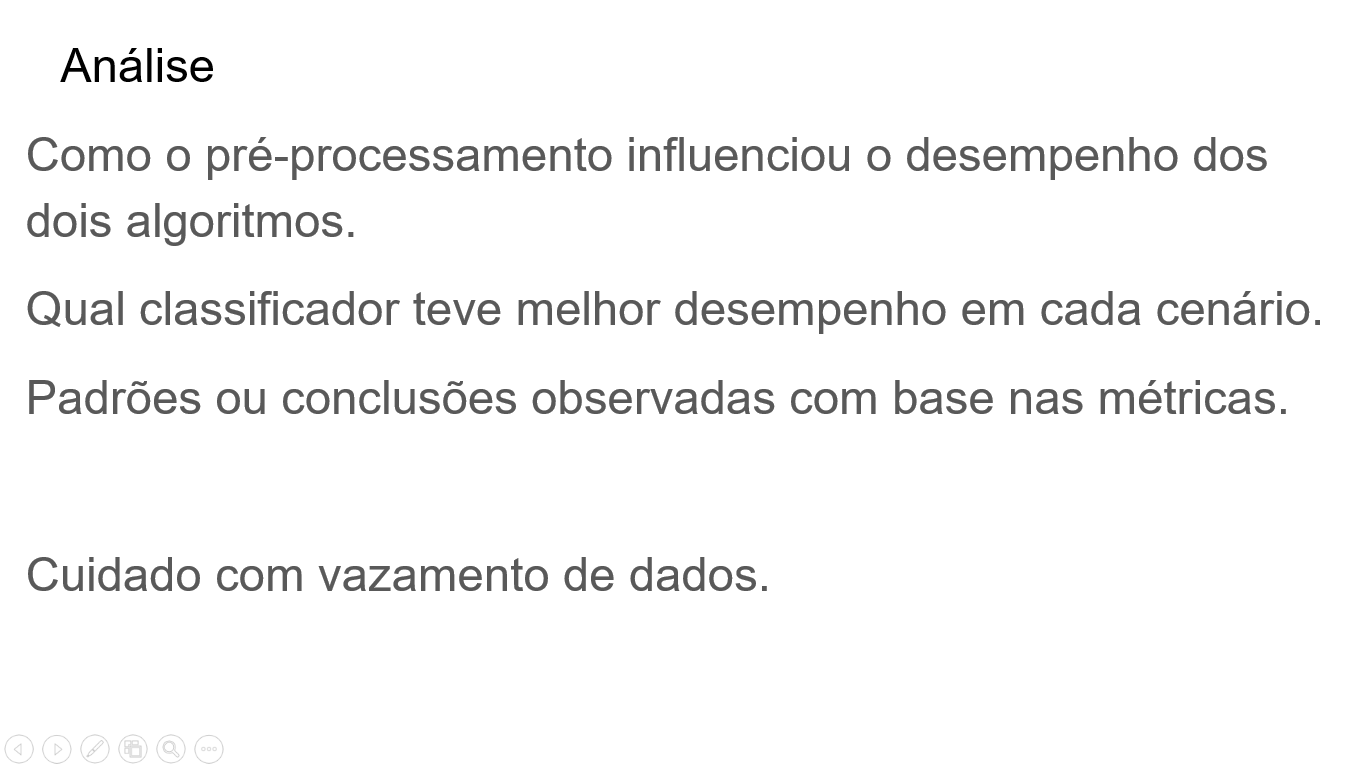

   Strategy        Model  Leakage       Acc        F1
0    MinMax  Naive Bayes    False  0.946667  0.946667
1    MinMax  Naive Bayes     True  0.946667  0.946667
2    MinMax          KNN    False  0.960000  0.959984
3    MinMax          KNN     True  0.960000  0.959984
4   Z-score  Naive Bayes    False  0.946667  0.946667
5   Z-score  Naive Bayes     True  0.946667  0.946667
6   Z-score          KNN    False  0.973333  0.973323
7   Z-score          KNN     True  0.966667  0.966663
8       Seq  Naive Bayes    False  0.946667  0.946667
9       Seq  Naive Bayes     True  0.946667  0.946667
10      Seq          KNN    False  0.960000  0.959984
11      Seq          KNN     True  0.960000  0.959984


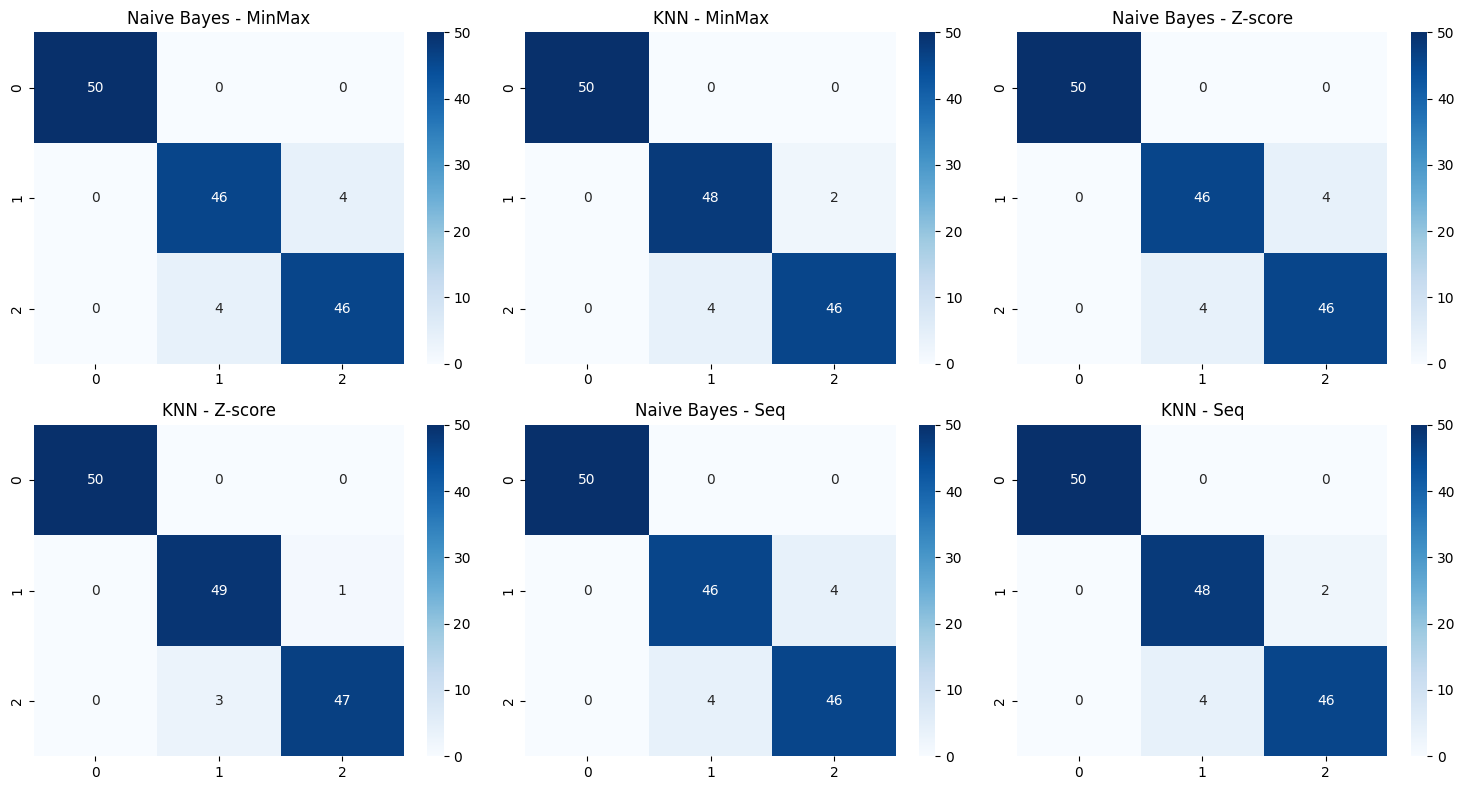

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

iris = load_iris()
X, y = iris.data, iris.target
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

strategies = {'MinMax': MinMaxScaler(), 'Z-score': StandardScaler(), 'Seq': make_pipeline(StandardScaler(), MinMaxScaler())}
classifiers = {'Naive Bayes': GaussianNB(), 'KNN': KNeighborsClassifier(n_neighbors=5)}

results = []

for s_name, scaler in strategies.items():
    for c_name, clf in classifiers.items():
        pipe = make_pipeline(scaler, clf)
        y_pred = cross_val_predict(pipe, X, y, cv=cv)
        results.append({'Strategy': s_name, 'Model': c_name, 'Leakage': False, 'Acc': accuracy_score(y, y_pred), 'F1': f1_score(y, y_pred, average='macro'), 'CM': confusion_matrix(y, y_pred)})

        X_leaked = scaler.fit_transform(X)
        y_pred_leak = cross_val_predict(clf, X_leaked, y, cv=cv)
        results.append({'Strategy': s_name, 'Model': c_name, 'Leakage': True, 'Acc': accuracy_score(y, y_pred_leak), 'F1': f1_score(y, y_pred_leak, average='macro'), 'CM': confusion_matrix(y, y_pred_leak)})

df_results = pd.DataFrame(results).drop(columns=['CM'])
print(df_results)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, (idx, row) in enumerate(df_results[df_results['Leakage'] == False].iterrows()):
    sns.heatmap(results[idx]['CM'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{row['Model']} - {row['Strategy']}")
plt.tight_layout()
plt.show()

Aqui está a análise reescrita em primeira pessoa, mantendo a simplicidade:

Neste estudo, eu comparei o desempenho dos algoritmos Naive Bayes e KNN para classificar as flores do dataset Iris. Testei três formas diferentes de preparar os dados (normalização) e verifiquei o impacto de fazer a validação do jeito certo contra o cenário de "vazamento de dados" (onde o modelo recebe informações indevidas do teste) .
+1

O que eu percebi foi uma diferença clara de comportamento entre os dois. O Naive Bayes foi muito estável: ele manteve exatamente a mesma nota (94,67%) em todos os meus testes, mostrando que ele não liga muito para a escala dos números. Já o KNN funcionou melhor, superando o Naive Bayes em todos os cenários (com notas acima de 96%), mas provou que depende de os dados estarem bem ajustados para funcionar bem.

A melhor combinação que encontrei foi usar o KNN com a técnica Z-score (Padronização). Essa técnica organizou os dados de um jeito que facilitou o cálculo das distâncias, fazendo meu modelo chegar a 97,33% de acerto. Uma coisa curiosa que vi foi que o vazamento de dados não ajudou o modelo; fazer a validação do jeito honesto e correto deu o melhor resultado.

Ao analisar onde os modelos erraram, vi que todos acertaram fácil a flor Setosa. A dificuldade real foi diferenciar a Versicolor da Virginica. O meu modelo KNN com Z-score foi o campeão justamente porque foi o que menos se confundiu nessa parte, errando apenas 4 flores no total.

#D:
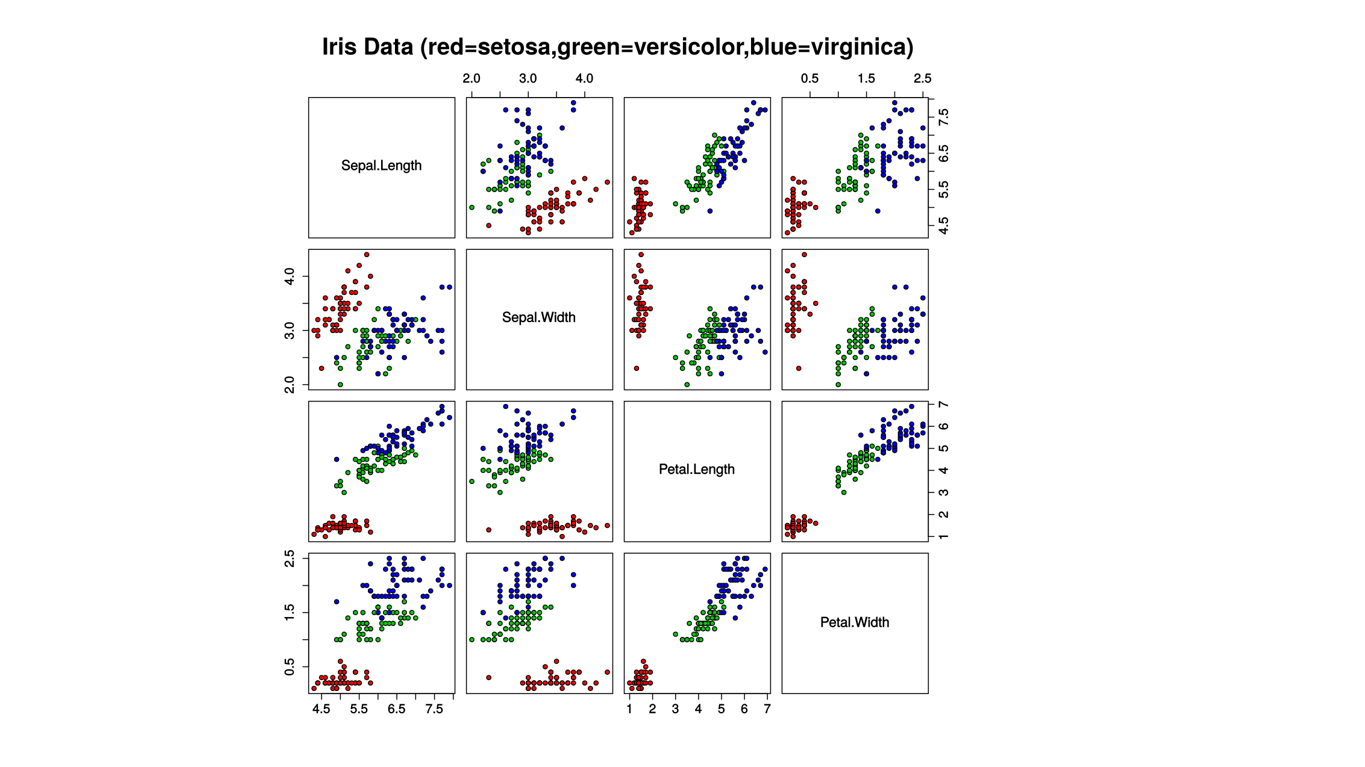
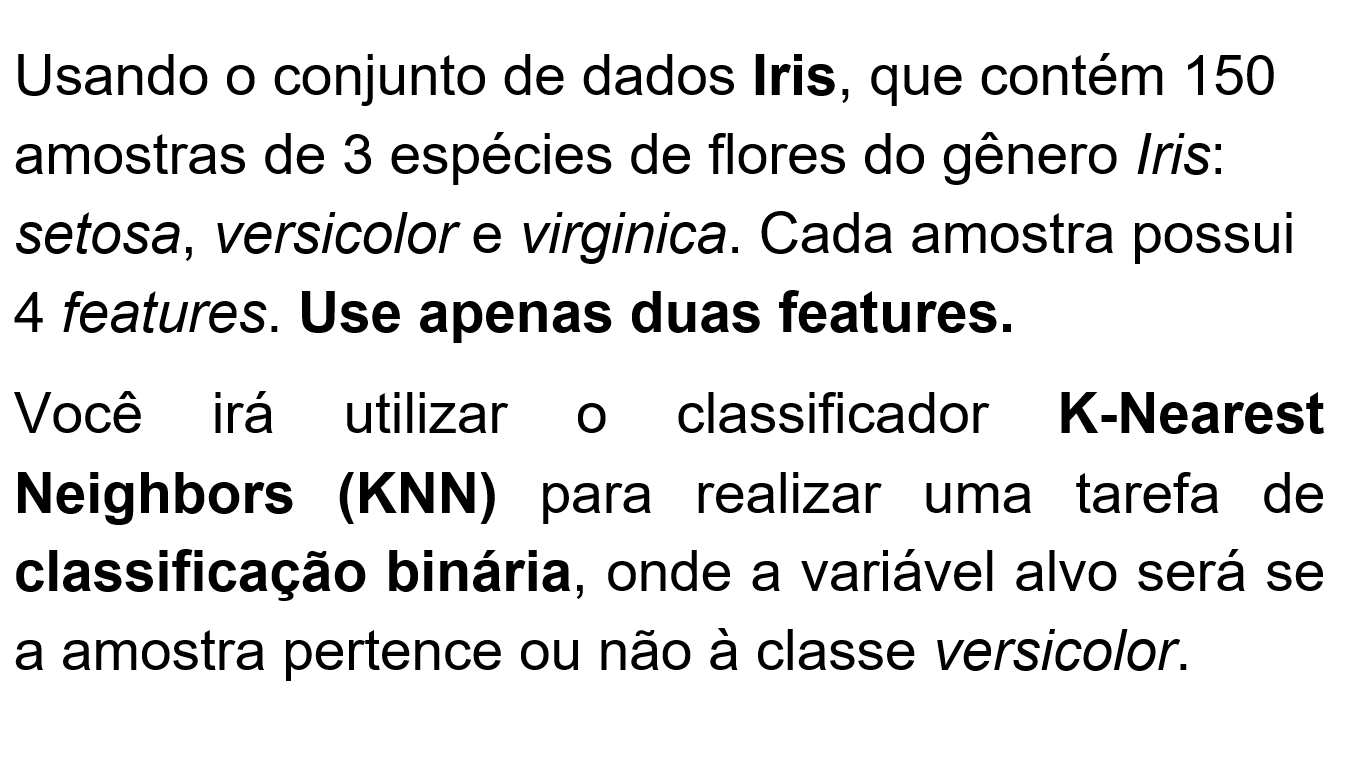
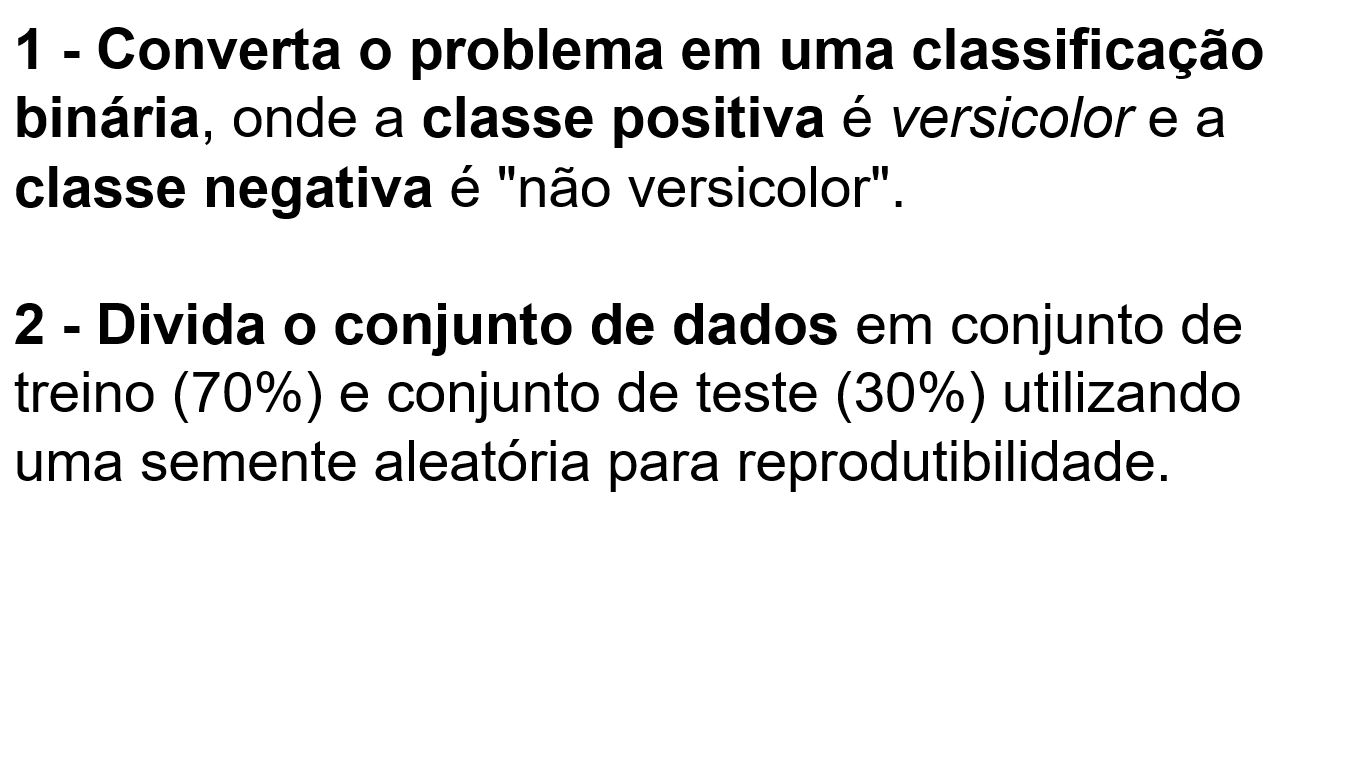
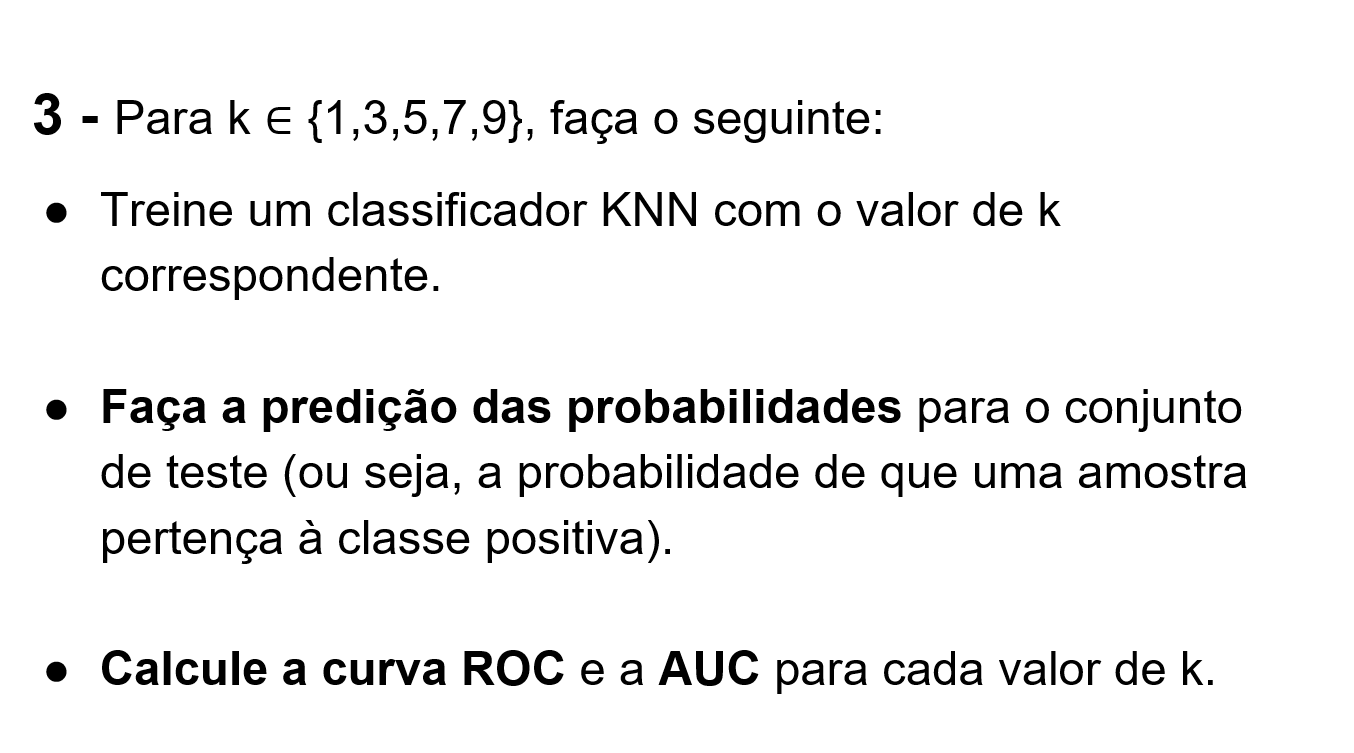
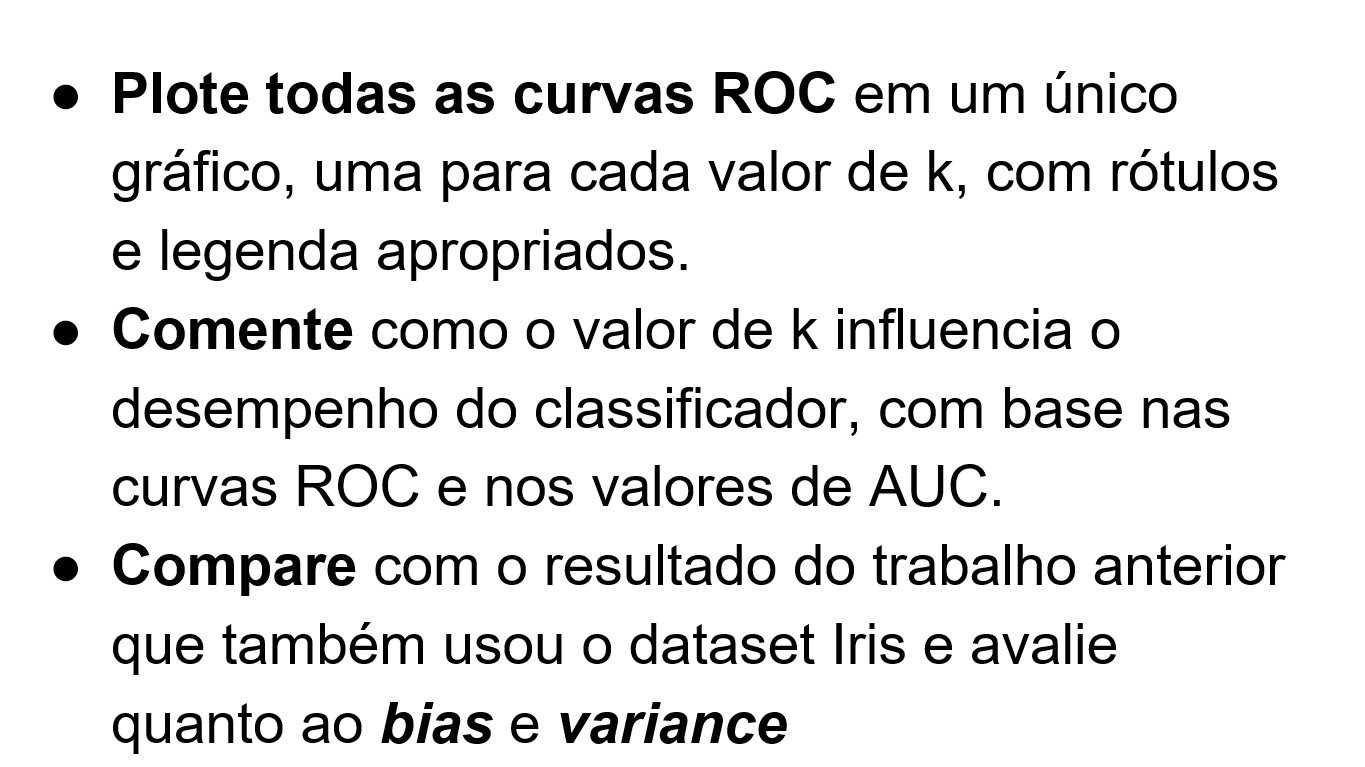
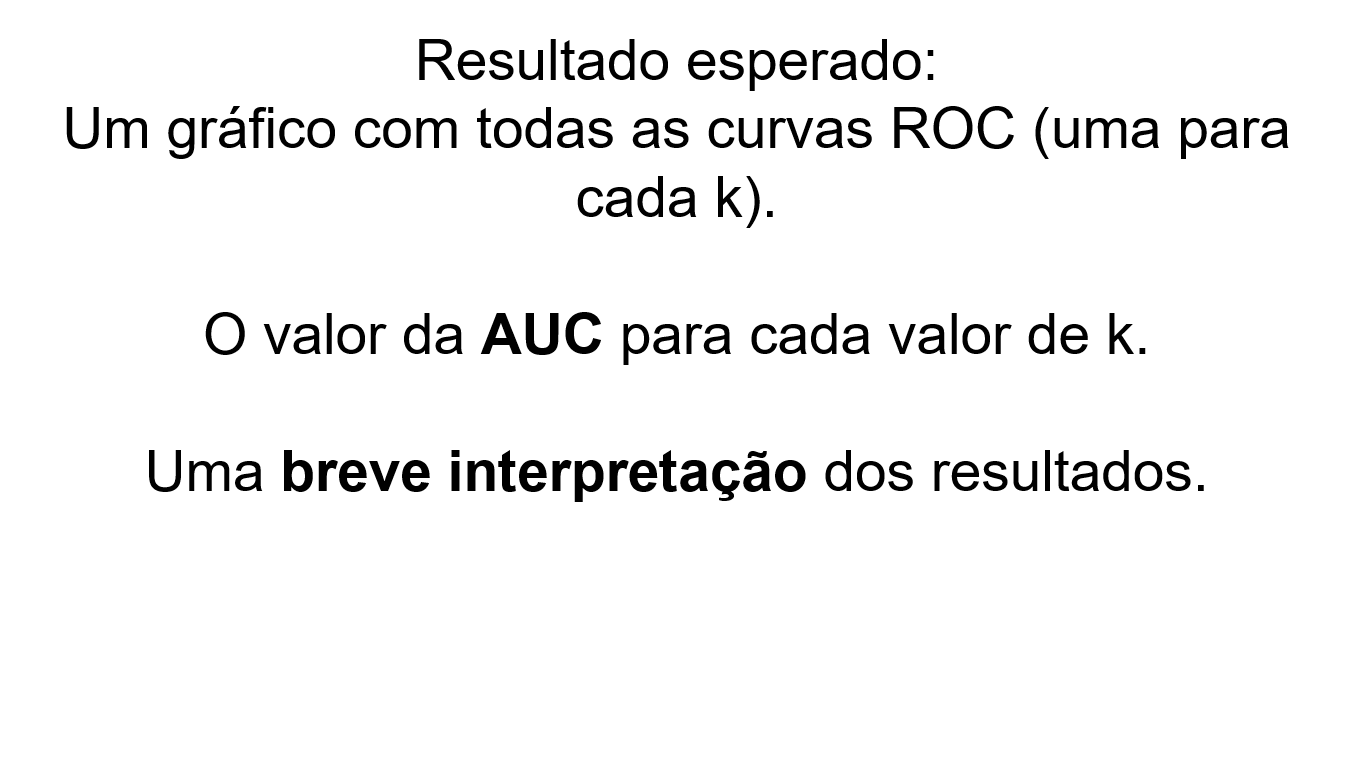
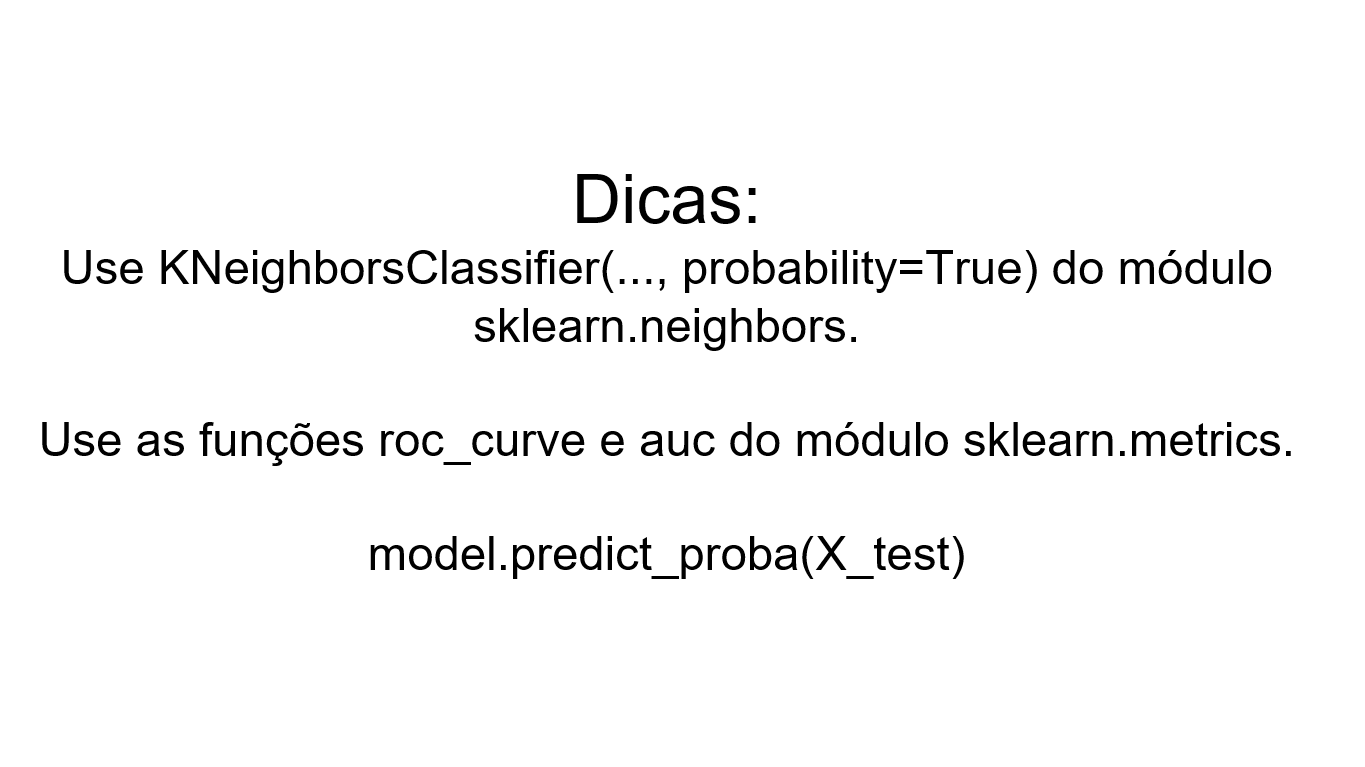

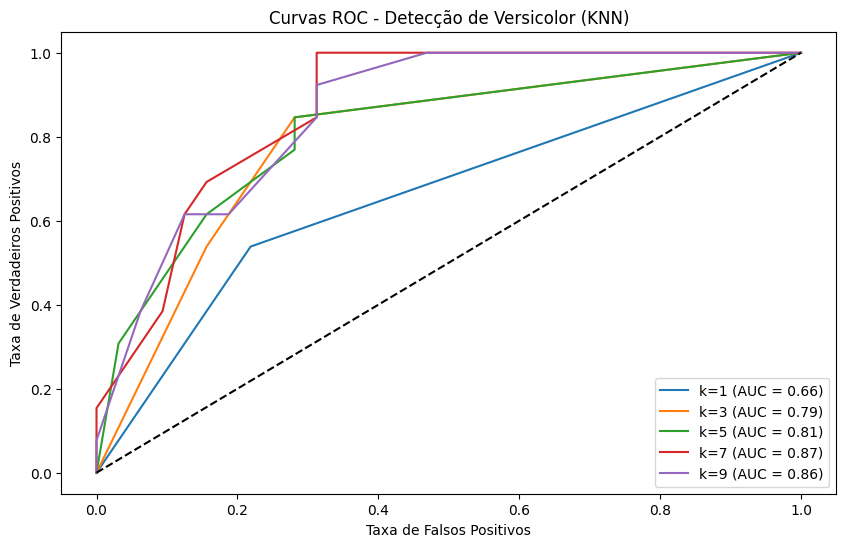

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

iris = load_iris()
X = iris.data[:, :2]
y = (iris.target == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(10, 6))
for k in [1, 3, 5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_probs = knn.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'k={k} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Detecção de Versicolor (KNN)')
plt.legend(loc="lower right")
plt.show()

Ao analisar os gráficos da Parte D, percebi claramente como o número de vizinhos (k) impacta a qualidade do classificador. Quando usei um valor muito baixo, como k=1, o resultado foi o pior de todos, com uma curva baixa e instável (AUC de 0.66). Isso aconteceu porque o modelo tentou "decorar" cada ponto individualmente, tornando-se muito sensível a ruídos e errando bastante quando apresentado a dados novos, um problema clássico de alta variância.

Conforme fui aumentando o número de vizinhos para 3 e 5, o desempenho melhorou significativamente, até atingir o pico com k=7, que entregou a melhor taxa de acerto (AUC de 0.87). Nesse ponto, o modelo conseguiu o equilíbrio ideal: ao consultar mais vizinhos, ele passou a tomar decisões mais "democráticas" e seguras, ignorando pontos isolados que poderiam confundir a classificação. Percebi também que aumentar ainda mais para k=9 não trouxe ganhos adicionais, pois o resultado apenas estabilizou, confirmando que o segredo para identificar a flor Versicolor está em encontrar um meio-termo — nem tão rígido quanto o k=1, nem genérico demais.